In [1]:
import yaeos
from yaeos import PengRobinson76, QMR
import numpy as np

In [12]:
# Number of components, for easier definition
nc = 2

# kij and lij matrices
k12 = 0.1
lij = kij = np.zeros((nc,nc))
kij[0,1] = kij[1,0] = k12

mixrule = QMR(kij, lij)

# Critical constants
Tc = [320, 375]
Pc = [30, 45]
w = [0.0123, 0.045]

model = PengRobinson76(Tc, Pc, w, mixrule)


n = [1.0, 0.2]
model.fugacity(n, v=2.0, t=303.15, dn=True)

{'ln_phi': array([2.3118468 , 2.33292475]),
 'dt': None,
 'dp': None,
 'dn': array([[-0.00186921,  0.00934604],
        [ 0.00934604, -0.04673019]])}

In [17]:
n = [0.4, 0.6]
Tc = [190.564, 425.12]
Pc = [45.99, 37.96]
w = [0.0115478, 0.200164]

lij = kij = np.zeros((nc,nc))
mixrule = QMR(kij, lij)
model = PengRobinson76(Tc, Pc, w, mixrule)

In [18]:
%%time
P, T = 60.0, 294.0

ts = np.linspace(200, 400, 50)
ps = np.linspace(30, 100, 50)
betas = []

t = []
p = []

for T in ts:
    for P in ps:
        flash = model.flash_tp(n, T, P)
        x = flash["x"]
        y = flash["y"]
        P = flash["P"]
        T = flash["T"]
        beta = flash["beta"]
        # x, y, P, T, Vx, Vy, beta = yaeos.yaeos_c.flash(id=model.id, z=n, p=P, t=T)
        t.append(T)
        p.append(P)
        betas.append(beta)

CPU times: user 500 ms, sys: 0 ns, total: 500 ms
Wall time: 500 ms


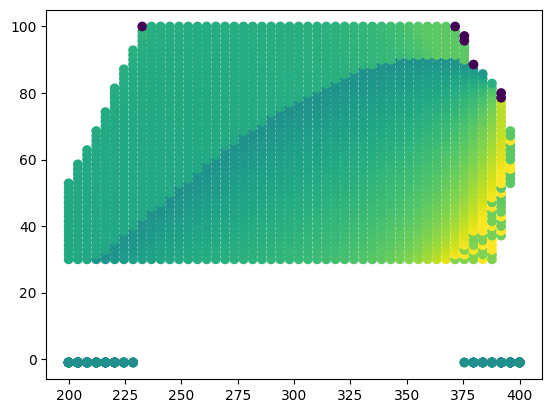

In [19]:
import matplotlib.pyplot as plt
plt.scatter(t, p, c=betas)

## Modified Huron-Vidal MixingRule

CPU times: user 3.62 s, sys: 0 ns, total: 3.62 s
Wall time: 3.63 s


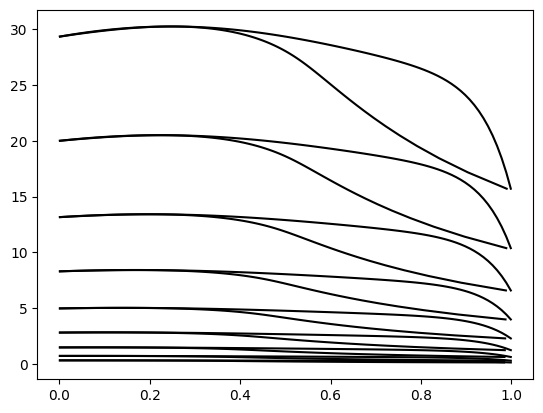

In [20]:
%%time
from yaeos import NRTL, MHV, PengRobinson76, yaeos_c, QMR
import numpy as np
import matplotlib.pyplot as plt

nc = 2
tc = [647.14, 513.92]
pc = [220.64, 61.48]
w =  [0.344, 0.649]

a = [[0, 3.458], [-0.801, 0]]
b = [[0, -586.1], [246.2, 0]]
c = [[0, 0.3], [0.3, 0]]

b = np.array(b)

ge_model = NRTL(a, b, c)
mixrule = MHV(ge_model, q=-0.53)

null_mixing = QMR(np.zeros((nc,nc)), np.zeros((nc,nc)))

model_stock = PengRobinson76(tc, pc, w, null_mixing)
model_mhv = PengRobinson76(tc, pc, w, mixrule)

colors = ["red", "green", "blue", "orange", "black"]
ts = np.linspace(50+273, 200+273, 9)
import time
for i, T in enumerate(ts):
    i=4
    xs = np.linspace(0.001, 0.999, 100)
    ys = []
    ps = []

    st = time.time()
    
    for x1 in xs:
        x = [x1, 1-x1]
        sat = model_mhv.saturation_pressure(x, T, "bubble")
        p, y = sat["P"], sat["y"]
        ps.append(p)
        ys.append(y[0])

    plt.plot(xs, ps, color=colors[i])
    plt.plot(ys, ps, color=colors[i])

# Phase envelope tracing

In [1]:
import yaeos
import matplotlib.pyplot as plt
import numpy as np
import chemicals


In [24]:
names = ["methane", "n-decane", "water", "hexatriacontane"]
chems = []

Tc = []
Pc = []
w = []
for c in names:
    chem = chemicals.CAS_from_any(c)
    Tc.append(chemicals.Tc(chem))
    Pc.append(chemicals.Pc(chem)/1e5)
    w.append(chemicals.acentric.omega(chem))

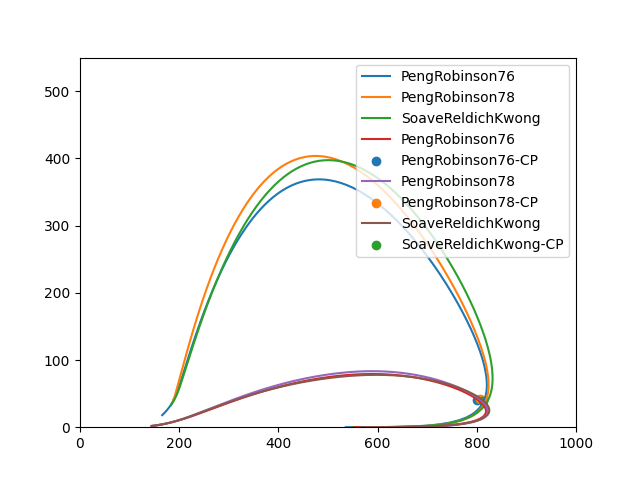

In [25]:
z = np.ones(len(names))
z = z/z.sum()

models = [
    yaeos.PengRobinson76,
    yaeos.PengRobinson78,
    yaeos.SoaveRedlichKwong,
]

for m in models:
    model = m(Tc, Pc, w)
    T, P, Tcs, Pcs = yaeos.yaeos_c.pt2_phase_envelope(model.id, z, kind="dew", t0=150, p0=0.01)
    plt.plot(T, P, label=model.name)
    plt.scatter(Tcs, Pcs, label=model.name + "-CP")

plt.legend()
plt.show()

In [26]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

interactive(children=(Dropdown(description='i', options=(0, 1, 2, 3), value=0), FloatSlider(value=0.4901, desc…

<function __main__.update(i, x, n)>

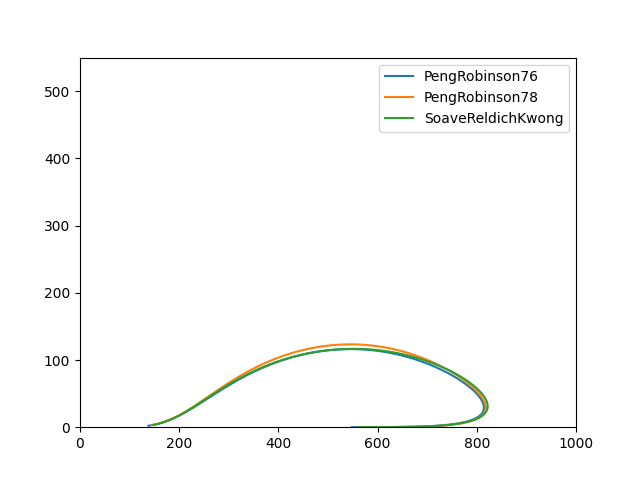

In [27]:
%matplotlib widget
x = np.linspace(-10, 10,100)

def f(x, A, B, C):
    return A*x**2 + B*x + C

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, f(x, A=1, B=1, C=1))


def run(i, x, n):
    z = np.ones(n)
    z[i] = x
    exclude = [i]
    mask = np.ones(z.shape, bool)
    mask[exclude] = False
    z[mask] = (1 - x)/2
    
    z = z/sum(z)
    print(z)

    models = [
        yaeos.PengRobinson76,
        yaeos.PengRobinson78,
        yaeos.SoaveRedlichKwong,
    ]

    ax.clear()
    for m in models:
        model = m(Tc, Pc, w)
        T, P, Tcs, Pcs = yaeos.yaeos_c.pt2_phase_envelope(model.id, z, kind="dew", t0=150, p0=0.01)
        ax.plot(T, P, label=model.name)
    plt.legend()
    
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 550)
    return T, P

def update(i, x, n):
    T, P = run(i, x, n)
    #line.set_xdata(T)
    #line.set_ydata(P)
    #fig.canvas.draw_idle()

interact(update, i=[i for i in range(len(Tc))], x=(0.0001, 0.9999, 0.01), n=fixed(len(Tc)))